# 25 - Classifying All-NBA Players (Part VII - Support Vector Machines)
Well, the last 2 posts was probably the most I've ever talked about trees in my life. I usually frequent [r/nba](http://www.reddit.com/r/nba) at least a few times a day, but no joke I accidentally googled 'r/trees' a few times just because I had trees on the mind and for some reason found myself much more relaxed than before.

<img src="https://img.buzzfeed.com/buzzfeed-static/static/2014-07/23/14/campaign_images/webdr05/32-ridicuously-entertaining-stoner-movies-2-21277-1406139324-0_dblbig.jpg" style="width: 400px;"/>

At this point, I'm pretty sick of trees. I have yet to explore gradient boosting trees, but that's probably a bit overkill for this application. I'm still super interested in it and will probably come back to gradient boosting when my tree meter isn't has high, so I'm going to look at the _**support vector machine**_ in this post.

The support vector machine... jesus what a stroke of genius. When I was reading [ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn/download.html), the SVM was _**by far**_ the most difficult chapter to complete. The SVM intrinsically is a collection of interesting mathematical ideas which, by themselves, are not the easiest to grasp, let alone put together in very intelligent ways.

I'll throw out this MIT video right off the bat because this was basically the video that made it click for me. Reading it in ESL was nice, and it's great to have a paper copy of the process and all those formulas, but you really need someone to take you by the hand and walk you through step by step to really grasp and appreciate the magic. Professor Patrick Winston is able to do it beautifully... on my 10th time watching the video anyways haha.

[![IMAGE ALT TEXT](http://img.youtube.com/vi/_PwhiWxHK8o/0.jpg)](http://www.youtube.com/watch?v=_PwhiWxHK8o "Video Title")

Essentially, the SVM is solving an optimization problem. To explain this optimization problem, it's much easier to start with a photo:

![](http://docs.opencv.org/2.4/_images/optimal-hyperplane.png)

Above, we have two classes of data, red and blue. Our goal, of course like any classification problem, is to separate them. The basic support vector concept tries to optimize the width of the margin generated by any separating hyperplane. The best separatin hyperplane has the _**widest margin**_ between the hyperplane itself and the closest _**support vectors**_ from the data. The support vectors from either class essentially essentially govern the best separating hyperplane because the observations directly impact the margin of the hyperplane. In a 2D space, the separating hyperplane is simply a line as shown above.

Through a bunch of mathematical conveniences and magic, our optimization problem ends up being "Find the maximum margin of the separating hyperplane under the constraint that the margin must be supported by at least 1 support vector from each class". Because of this optimization under a constraint, Vladamir Vapnik used the Legrange dual form to yield to the following optimization problem (please watch all the video for all the preamble I just skipped over):

$$L(x,y,\alpha)=\sum{\alpha_{i}}-\frac{1}{2}\sum_{i}\sum_{j}{}\alpha_{i}\alpha_{j}y_{i}y_{j}\vec{x_{i}}\cdot\vec{x_{j}}$$

And essentially the optimization function _**only depends on the inner product of the observations**_. That is _**crazy**_. That's magic trick \#1, but there's probably an _**even crazier**_ magic trick \#2!

The above is purely assumed on a linear separating hyperplane, but it doesn't necessarily restrict us to any dimensions. Because our data in our example is 2D, it turns out that our separating hyperplane is a 1D line. What if our data was in 3D? Our separating hyperplane would be a 2D plane! What if we transformed $x_{i}$ and $x_{j}$ with $\phi(x_{i})$ and $\phi(_{j})$? We'd end up calculating $\phi(\vec{x_{i}})\cdot\phi(\vec{x_{j}})$. The $\phi()$ function, whatever it ends up being, can be something that transforms our data set from the 2D space into the 3D space. A great SVM illustration of this transformation can be seen here:

[![IMAGE ALT TEXT](http://img.youtube.com/vi/3liCbRZPrZA/0.jpg)](http://www.youtube.com/watch?v=3liCbRZPrZA "Video Title")

See that, using the transformation in a 3D space, we could still actually fit a _**linear**_ hyperplane even though back in the 2D world the boundary becomes non-linear. Well, how do we know what these transformations are? This is where magic trick \#2 comes in. Magic trick \#2 is that the $\phi(\vec{x_{i}})\cdot\phi(\vec{x_{j}})$ calculation can often be replaced by another function $K(x_{i},x_{j})$.

For example, if we wanted to transform our $x$, we may want some transformation that throws in higher polynomial terms... maybe get some $x^2$ and $x^3$s in there. Sometimes, when we have these terms in there, their dot product can actually be represented by a very simple Kernel function that is very efficient to compute. Instead of trying to figure out what the transformations should be and what dimension would best allow us to split the data, we can just calculate the simple Kernel function instead! Itt even turns out that some Kernels represent infinite dimensions, so we are getting more dimensions for free, and we don't even have to worry about what dimension it went into!

[![IMAGE ALT TEXT](http://img.youtube.com/vi/OmTu0fqUsQk/0.jpg)](http://www.youtube.com/watch?v=OmTu0fqUsQk "Video Title")

The video above goes a bit more into the math if you're interested.

One more problem remains, and that is, what if there really exists no completely separating hyperplane, or what if we don't want to go into a dimension where one exists (perhaps we're purposely trying to avoid non-linear boundaries for overfitting and complexity)? The support vector machine defines a penalty for any observations that cross the margin, and this can be one way of allowing a soft margin classifier.

Okay, that about wraps it up as an intro, let's try it out!

In [1]:
# Load libraries & initial config
%load_ext rpy2.ipython

%R library(ggplot2)
%R library(gridExtra)
%R library(scales)
%R library(ggbiplot)
%R library(dplyr)

%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Retrieve team stats from S3
playerAggDfAllNbaAllStar = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfAllNbaAllStar.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfAllNbaAllStar.dtypes))
print playerAggDfAllNbaAllStar.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

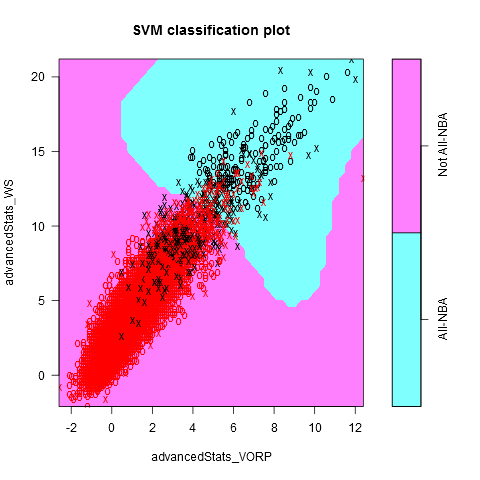

In [80]:
%%R -i playerAggDfAllNbaAllStar -o svmModelSummary
library(e1071)

# Build SVM model
svmModel = svm(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,
    playerAggDfAllNbaAllStar,
    probability = TRUE
)

# Summary from model
svmModelSummary = summary(svmModel)

# Plot SVM boundary
plot(svmModel, playerAggDfAllNbaAllStar, advancedStats_WS ~ advancedStats_VORP)

In [81]:
print svmModelSummary



Call:

svm(formula = accolades_all_nba ~ advancedStats_WS + advancedStats_VORP, 

    data = playerAggDfAllNbaAllStar, probability = TRUE)





Parameters:

   SVM-Type:  C-classification 

 SVM-Kernel:  radial 

       cost:  1 

      gamma:  0.5 



Number of Support Vectors:  711



 ( 339 372 )





Number of Classes:  2 



Levels: 

 All-NBA Not All-NBA









Alright, Imma just check out the ROC real quick to see how this model performs. The boundary seems quite smooth and doesn't seem too prone to overfitting, so I just wonder. Note I initially fit the model above without the 'probability' flag as TRUE, and it has to be flagged if we want to get the probabilities to build the ROC curve.

Alright here's an edit after I've already tried some stuff. So it looks like the svm() package has been updated quite a bit, and as the package was updated over time, there's been new features built in in "tricky" ways.

In trying to get the probability outputs (also, how exactly does SVM get probability outputs even?), I actually have to train the model is a different way. The 'R' way of training models in most packages is to use the Y ~ X1 + X2 + ... + XN notation. Models trained on this notation, for some reason, don't predict correctly. When I used that model to predict, I was missing ~200 observations for some reason. It only returned 11000 something predictions when I have 13220 observations in my data set. I confirmed that there were no missing values from the WS and VORP metrics (otherwise none of my previosu models would've worked either), and I can't quite figure out what's wrong.

When I tried to build the model using the legacy format, specifically providing x and y dataframes below, I was able to get the correct number of predictions and build a ROC curve. Results below.

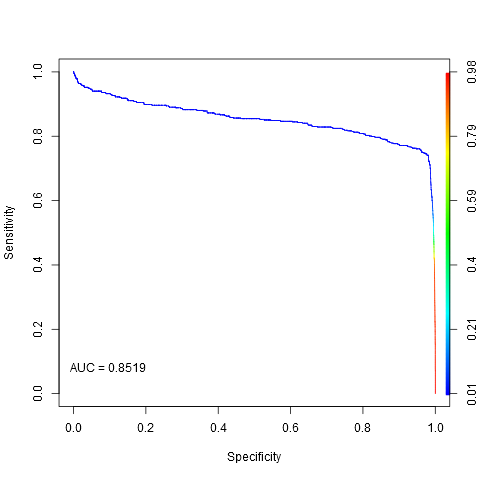

In [84]:
%%R
library(ROCR)

# Generate x and y variables
x = playerAggDfAllNbaAllStar[,c('advancedStats_WS', 'advancedStats_VORP')]
y = playerAggDfAllNbaAllStar[,c('accolades_all_nba')]

# Build SVM model
svmModelOld = svm(
    x,
    y,
    probability = TRUE
)

# Use the tree library to predict probabilities
svmModelOldPred = predict(svmModelOld, x, probability = TRUE)

# Use the ROCR library to build the ROC curve
svmModelOldPredObj = prediction(as.data.frame(attr(svmModelOldPred, "probabilities")[,1]), ifelse(playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
svmModelOldRocEval = performance(svmModelOldPredObj, 'sens', 'spec')
plot(svmModelOldRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(svmModelOldPredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

In [85]:
# Retrieve the iterative cut-off sensitivity analysis that logistic regression did behind the scenes
%R cutoffs = data.frame(cut = svmModelOldRocEval@alpha.values[[1]], sens = svmModelOldRocEval@x.values[[1]], spec = svmModelOldRocEval@y.values[[1]])

# Calculate the metrics sensitivity + specificity. This will help us gauge the accuracy of both classes simultaneously.
#   E.g. if we were guessing each class 100% correctly (there is a very distinct decision boundary), then we would have 1 + 1 = 2
%R cutoffs['sens_plus_spec'] = cutoffs['sens'] + cutoffs['spec']

# See the last few rows of this dataframe where the sensitivity + specificity are at its max
%R tail(cutoffs[order(cutoffs$sens_plus_spec),])

,cut,sens,spec,sens_plus_spec
549,0.018712,0.976411,0.745020,1.721431
534,0.018724,0.980421,0.741036,1.721457
533,0.018725,0.980500,0.741036,1.721536
548,0.018712,0.976569,0.745020,1.721589
532,0.018728,0.980579,0.741036,1.721615
547,0.018712,0.976647,0.745020,1.721667


Pretty bad results! Not the greatest AUC (10%+ worse than what we're used to seeing) and also predicts non all-NBA players at quite a bad rate.

A few questions running through my mind that I have to answer... First of all, let me understand how an SVM even predicts probabilities. At the end of the day, it's just a plane that we're modelling right? How does that plane get translated into probabilities?

Alrighty, looking at the svm() documentation, it looks like:

> The probability model for classification fits a logistic distribution using maximum likelihood to the decision values of all binary classifiers, and computes the a-posteriori class probabilities for the multi-class problem using quadratic optimization. The probabilistic regression model assumes (zero-mean) laplace-distributed errors for the predictions, and estimates the scale parameter using maximum likelihood.

Okay, so it looks like the probabilities actually have nothing to do with the SVM classifier itself. In fact, it's just using SVM to classify binary labels, and then a logistic regression is fit on these labels (although I will not leave out the possibility that I'm completely misunderstanding this blurb as well). That feels a bit too far removed from me actually trying to measure the SVM, so I'm going to prevent myself from going any further from a probability perspective here. I'll revert back to measuring model accuracy from misclassification error.

If we remove ourselves from the probability calculations and focus back on the svm() classifier, we can shift our attention to how to tune the model. There are quite a few parameters for the svm() function...
- kernel - type of kernel (linear, polynomial, radial basis, sigmoid)
- degree - degree of polynomial kernel
- gamma - some tuning parameter for all kernels except linear
- cost - cost of contraint violations

Just to try out a few parameters... let's just see what changing the kernel gives us.

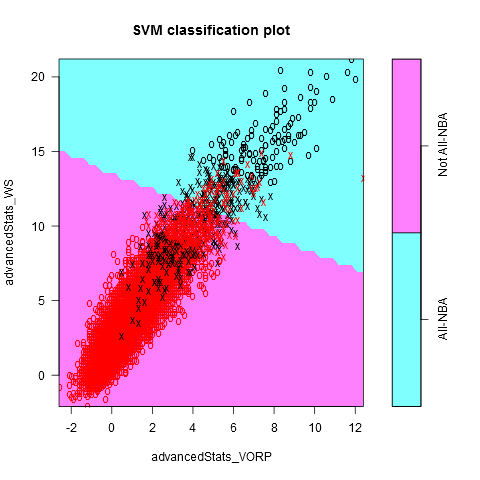

In [86]:
%%R

# Build SVM model
svmModel = svm(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,
    playerAggDfAllNbaAllStar,
    kernel = 'linear'
)

# Plot SVM boundary
plot(svmModel, playerAggDfAllNbaAllStar, advancedStats_WS ~ advancedStats_VORP)

Very similar to our manually selected and LDA boundary!

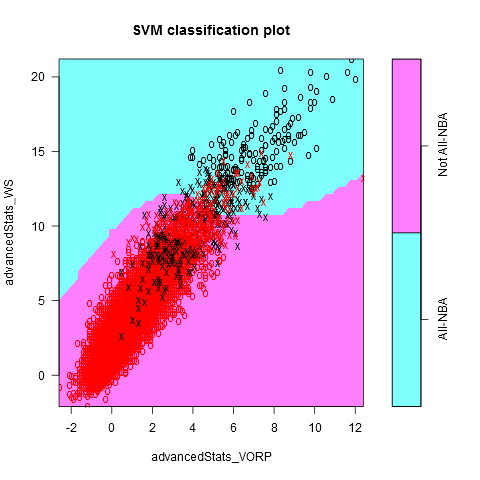

In [87]:
%%R

# Build SVM model
svmModel = svm(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,
    playerAggDfAllNbaAllStar,
    kernel = 'polynomial'
)

# Plot SVM boundary
plot(svmModel, playerAggDfAllNbaAllStar, advancedStats_WS ~ advancedStats_VORP)

Interesting. The default degree of polynomial is 3... what if we change that?

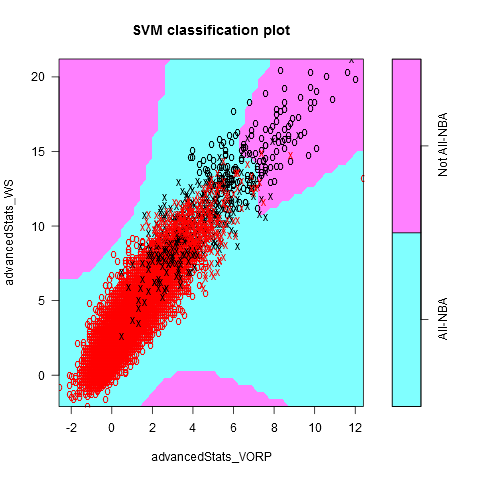

In [89]:
%%R

# Build SVM model
svmModel = svm(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,
    playerAggDfAllNbaAllStar,
    kernel = 'polynomial',
    degree = 6
)

# Plot SVM boundary
plot(svmModel, playerAggDfAllNbaAllStar, advancedStats_WS ~ advancedStats_VORP)

Hmm, as I type this, the model is still being built. This is taking a _**while**_. That took about 30 seconds to run, and the result is actualy pretty horrible. It's almost modelled the data backwards... Let's try a lower degree poly.

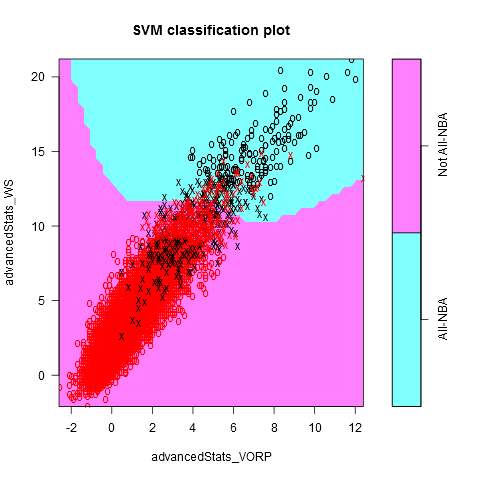

In [90]:
%%R

# Build SVM model
svmModel = svm(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,
    playerAggDfAllNbaAllStar,
    kernel = 'polynomial',
    degree = 4
)

# Plot SVM boundary
plot(svmModel, playerAggDfAllNbaAllStar, advancedStats_WS ~ advancedStats_VORP)

This one is similar to the radial basis kernel. Let's check out the sigmoid one for fun too.

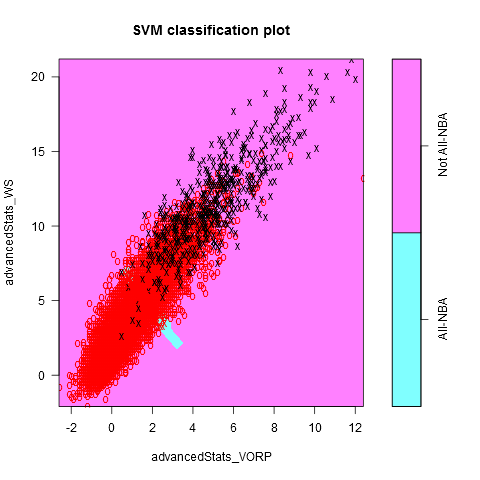

In [91]:
%%R

# Build SVM model
svmModel = svm(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,
    playerAggDfAllNbaAllStar,
    kernel = 'sigmoid'
)

# Plot SVM boundary
plot(svmModel, playerAggDfAllNbaAllStar, advancedStats_WS ~ advancedStats_VORP)

No idea what happened here lol. Maybe I have to tweak some other parameters. I'm also not giving myself enough credit it completely understand these kernels. Let's back back to linaer and check out cost.

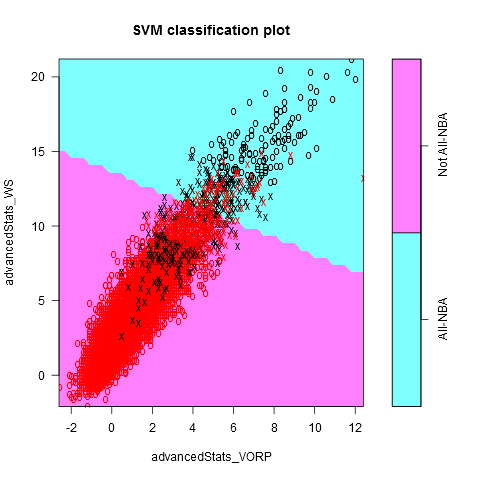

In [97]:
%%R

# Build SVM model
svmModel = svm(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,
    playerAggDfAllNbaAllStar,
    kernel = 'linear',
    cost = 1000
)

# Plot SVM boundary
plot(svmModel, playerAggDfAllNbaAllStar, advancedStats_WS ~ advancedStats_VORP)

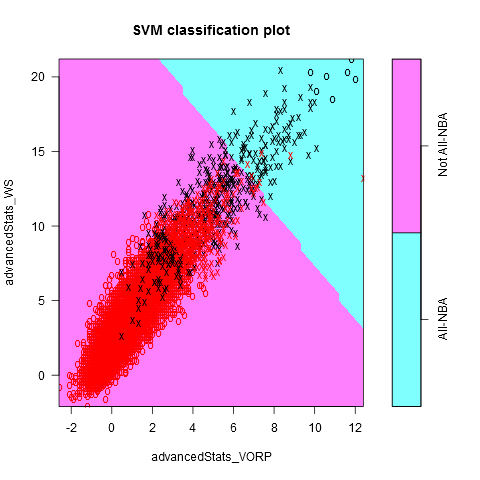

In [102]:
%%R

# Build SVM model
svmModel = svm(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,
    playerAggDfAllNbaAllStar,
    kernel = 'linear',
    cost = 0.001
)

# Plot SVM boundary
plot(svmModel, playerAggDfAllNbaAllStar, advancedStats_WS ~ advancedStats_VORP)

So cost dictates how much of a penalty is given to those observations that are on the wrong side of the separating hyperplane. The higher the cost, the more magnified the errors are. It's worth to note here that the errors are not simply misclassification loss, but it's quantified by the distance away from the margin as well.

We see when cost = 1000, otherwise, cost is large, it balances the boundaries between the two classes a bit better. It's trying to find the sweet spot where the errors are spread out a bit more among the two classes.

When cost = 0.001, otherwise, cost is small, the model takes more support vectors into account, and we can see that the support many more support vectors of the non all-NBA class pushes the boundary out more, and since we're not penalizing misclassifications that much (hardly any penalty at all), we let the boundary be pushed back while seemingly the majority of all-NBA players are now being misclassified.

It's known that a large C can tend to overfit, but in this model specifically on this data set specifically, a large C actually does exactly what we want it to do. We're trying to classify _**both**_ classes as well as possible, and we need to find that balance where both classes are being equally penalized and one class isn't being overpowered by the other simply based on sample size.

Let's try to look at the same exercise for the radial kernel.

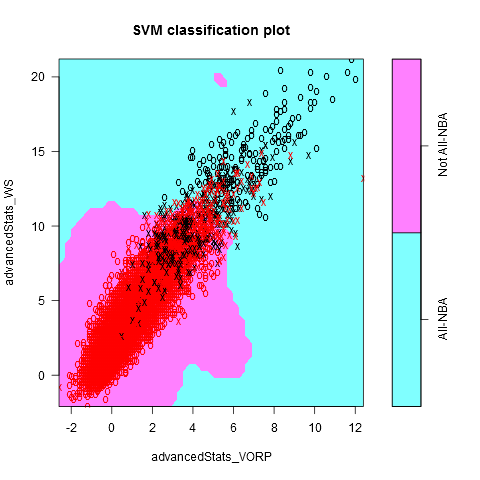

In [103]:
%%R

# Build SVM model
svmModel = svm(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,
    playerAggDfAllNbaAllStar,
    kernel = 'radial',
    cost = 1000
)

# Plot SVM boundary
plot(svmModel, playerAggDfAllNbaAllStar, advancedStats_WS ~ advancedStats_VORP)

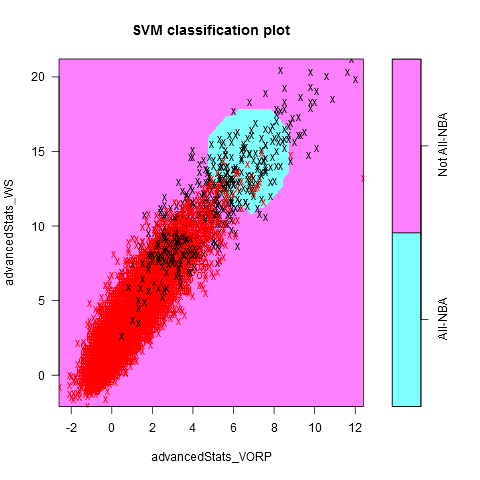

In [104]:
%%R

# Build SVM model
svmModel = svm(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,
    playerAggDfAllNbaAllStar,
    kernel = 'radial',
    cost = 0.01
)

# Plot SVM boundary
plot(svmModel, playerAggDfAllNbaAllStar, advancedStats_WS ~ advancedStats_VORP)

We see a very similar idea where , again, the "overfit" model is actually giving us what we want. With too low of a cost, the all-NBA class just gets overpowered on sample size (remember less than 5% of our entire population is all-NBA).

The svm() class gives us some great options to tune these parameters by cross validation as well using the tune() function.

In [121]:
%%R -o svmModelTuned

# Tune svm parameter with various kernel and cost parameters
svmModelTuned = tune(
    svm,
    train.x = x,
    train.y = y,
    ranges = list(
        kernel = c('linear', 'radial'),
        cost = 10^(-1:2)
    )
)

Wow, that took a while. The tune parameter by default finds the best parameters that we've specified by performin 10-fold cross validation.

We're testing values for linear / radial kernels and 4 different cost values (0.1, 1, 10, 100). We're already training $2\times 4=8$ models, but we're actually training each of these 10 times on 90% of the data as well because we're performing 10-fold cross validation... so we're actually training _**80**_ models!! We saw for larger values of cost for the radial kernel, even training a single model took a while...

If each takes an average 10 seconds to train, 80 models takes 800 seconds or ~13 minutes! Let's see how long this takes... I'm gonna go make lunch.

Ok that took just shy of 10 minutes... decently close!

In [125]:
%%R -o svmModelTunedPerformance

# Grab the performance matrix and pass to python to output
svmModelTunedPerformance = svmModelTuned$performances

In [126]:
print svmModelTunedPerformance

   kernel   cost     error  dispersion
1  linear    0.1  0.023676    0.003891
2  radial    0.1  0.024206    0.004112
3  linear    1.0  0.023903    0.004100
4  radial    1.0  0.023903    0.003877
5  linear   10.0  0.023979    0.003988
6  radial   10.0  0.023601    0.003360
7  linear  100.0  0.023979    0.003988
8  radial  100.0  0.023601    0.003435


We see the error here I can only assume is misclassification error. Again, we aren't too happy with misclassification error in general due to factors we've discussed in previous posts, namely our all-NBA observations are so sparse that less than 5% of the data is actually all-NBA to begin with so if we just always guess non all-NBA our model will still have only ~5% error. This SVM is an improvements, but we've really been measuring our model on sensitivity and specificity...

Let's take a look at the "best" model anyways

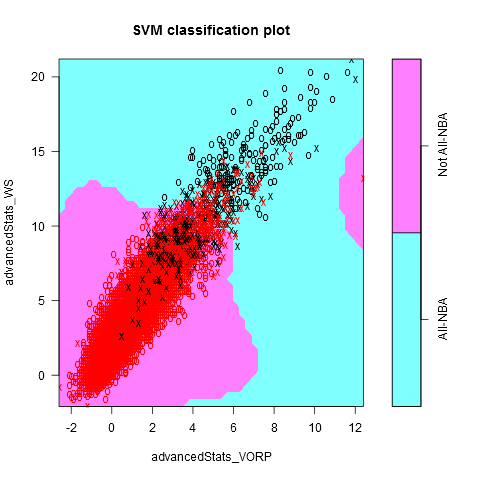

In [127]:
%%R

# Build SVM model
svmModel = svm(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,
    playerAggDfAllNbaAllStar,
    kernel = 'radial',
    cost = 100
)

# Plot SVM boundary
plot(svmModel, playerAggDfAllNbaAllStar, advancedStats_WS ~ advancedStats_VORP)

I've been a bit inconsistent because I never actually put the cost = 1000 parameter into my model, but I was using 1000 as a test when I was just looking at different models before. 1000 would've probably bumped my computation costs up by quite a bit as well. Looking at the boundary between 100 and 1000 though, there isn't too much of a difference. Our 100 model picks up an outlier on the right-most side of the plot. It's probably not that important because there literally has only ever been 1 player over there, so for all intents and purposes cost = 100 and cost = 1000 yield almost the same graph.

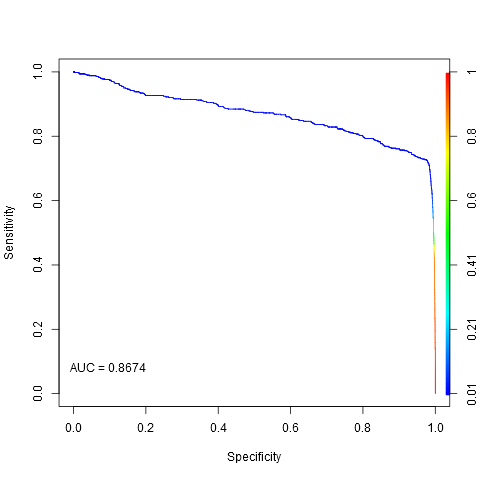

In [130]:
%%R

# Build SVM model
svmModelOld = svm(
    x,
    y,
    probability = TRUE,
    kernel = 'radial',
    cost = 100
)

# Use the tree library to predict probabilities
svmModelOldPred = predict(svmModelOld, x, probability = TRUE)

# Use the ROCR library to build the ROC curve
svmModelOldPredObj = prediction(as.data.frame(attr(svmModelOldPred, "probabilities")[,1]), ifelse(playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
svmModelOldRocEval = performance(svmModelOldPredObj, 'sens', 'spec')
plot(svmModelOldRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(svmModelOldPredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

Alright, I know I'm all over the place for this post, but I wanted to reach back into the probabilities bag and see what the ROC for our optimized model looks like. Again, I don't feel too comfortable using this probability calculation but it's all I got for ROC!!! Regardless, it only does slightly better than our first model where we looked at the ROC... unfortunately. How can this be so? Our QDA model looked similar, and it was also pretty one-sided, misclassifying all-NBA players like we're doing here... I think our other models like logistic regression and trees were actually cutting deeper into the non all-NBA cluster, which is what increasing our costs is seeming to do... what if we increase our costs like crazy here?

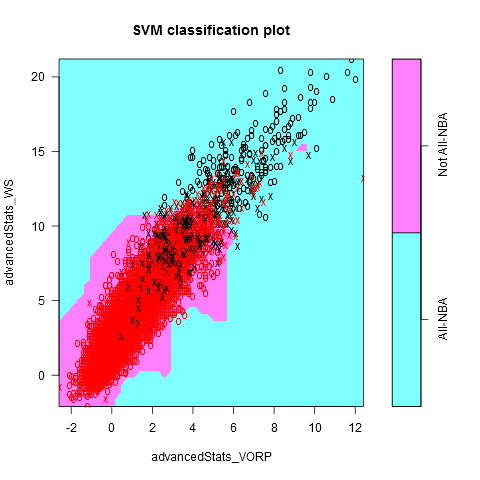

In [131]:
%%R

# Build SVM model
svmModel = svm(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,
    playerAggDfAllNbaAllStar,
    kernel = 'radial',
    cost = 10000
)

# Plot SVM boundary
plot(svmModel, playerAggDfAllNbaAllStar, advancedStats_WS ~ advancedStats_VORP)

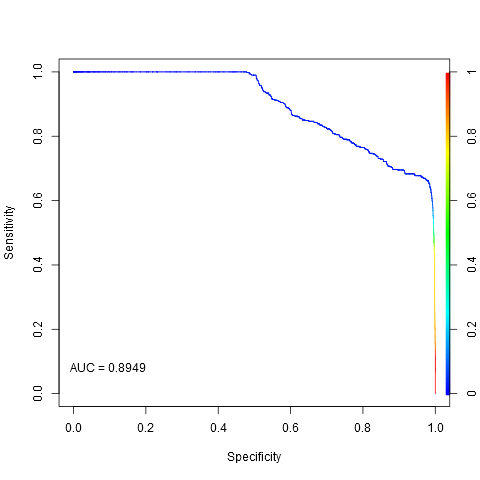

In [132]:
%%R

# Build SVM model
svmModelOld = svm(
    x,
    y,
    probability = TRUE,
    kernel = 'radial',
    cost = 10000
)

# Use the tree library to predict probabilities
svmModelOldPred = predict(svmModelOld, x, probability = TRUE)

# Use the ROCR library to build the ROC curve
svmModelOldPredObj = prediction(as.data.frame(attr(svmModelOldPred, "probabilities")[,1]), ifelse(playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
svmModelOldRocEval = performance(svmModelOldPredObj, 'sens', 'spec')
plot(svmModelOldRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(svmModelOldPredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

First of all, holy cow that took long to train again... Second of all... it's not doing much better. It seems to have found the optimal boundary it likes between the two classes (~10 WS & ~5 VORP), and the rest of the boundary just seems to be wrapping around the non all-NBA cluster. Perhaps if I actually take my cost high enough, the sens / spec metrics will improve, but it already took so long to train this one haha. OK... LET'S ADD 1 MORE 0 and SEE HOW IT GOES...

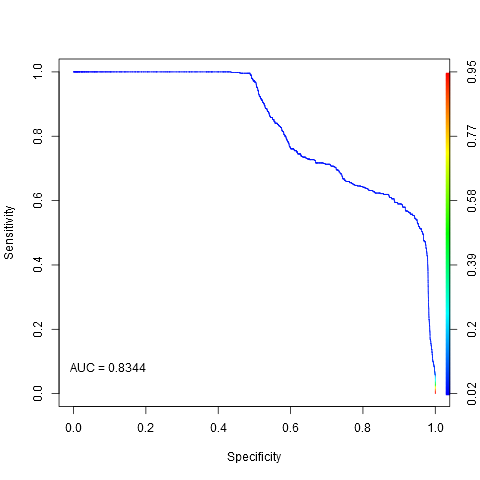

In [133]:
%%R

# Build SVM model
svmModelOld = svm(
    x,
    y,
    probability = TRUE,
    kernel = 'radial',
    cost = 100000
)

# Use the tree library to predict probabilities
svmModelOldPred = predict(svmModelOld, x, probability = TRUE)

# Use the ROCR library to build the ROC curve
svmModelOldPredObj = prediction(as.data.frame(attr(svmModelOldPred, "probabilities")[,1]), ifelse(playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
svmModelOldRocEval = performance(svmModelOldPredObj, 'sens', 'spec')
plot(svmModelOldRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(svmModelOldPredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

Wow, it's actually worse. I'm at somewhat of a loss and I'm not sure if we'll be able to really improve this classifier with my dumb brain.